In [1]:
# With transformataions and 320x320

# %%
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

# %%
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# %%
# Train-val split
data_dir = '../isic2019_modified/isic2019_modified'
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'

num_classes = 5  # Change this based on your dataset
batch_size = 32
num_epochs = 20
class_weights_tensor = torch.tensor([0.4637030299585015, 0.20220567335569326, 0.2313683133420499, 0.033141947586834176, 0.06958103575692115], dtype=torch.float).to(device)

# %%
# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
    ]),
}

# %%
# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4),
}


# %%
class MobileNetCustom(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetCustom, self).__init__()
        weights = MobileNet_V3_Large_Weights.IMAGENET1K_V2 # Load pretrained mobilenet
        self.mobilenet = mobilenet_v3_large(weights=weights)

        num_input_features = 960

        # Replace the last fully connected layer with a new one
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),  # Dropout layer to reduce overfitting
            nn.Linear(num_input_features, num_classes)
        )

    def forward(self, x):
        # Forward pass through MobileNet backbone
        x = self.mobilenet.features(x)

        # Global Average Pooling (GAP)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))

        # Flatten feature map
        x = torch.flatten(x, 1)

        # Forward pass through custom classifier
        x = self.mobilenet.classifier(x)
        return x

# %%
# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
model = MobileNetCustom(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



cpu


In [6]:
# %%
# Training loop
print("Start training")
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloaders["train"]) 
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}\n')

    # Update the learning rate
    scheduler.step()

    # After each epoch, evaluate accuracy on the validation set
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

    epoch_acc = correct / total 
    val_epoch_loss = val_running_loss / len(dataloaders["val"])

    print(f'Validation Accuracy after epoch {epoch+1}: {epoch_acc:.4f}, Loss: {val_epoch_loss:.4f}\n')

    # Save the model if it has a better accuracy than the best model seen so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), 'mobilenet_320_best_with_trans.pth')
        print('Model saved as mobilenet_320_best_with_trans.pth\n')

print('Finished Training')


Start training
Epoch 1, Loss: 0.6238

Validation Accuracy after epoch 1: 0.6633, Loss: 0.8986

Model saved as best_model_with_trans_big.pth

Epoch 2, Loss: 0.5188

Validation Accuracy after epoch 2: 0.7011, Loss: 0.8950

Model saved as best_model_with_trans_big.pth

Epoch 3, Loss: 0.4823

Validation Accuracy after epoch 3: 0.6857, Loss: 0.8993

Epoch 4, Loss: 0.4439

Validation Accuracy after epoch 4: 0.6792, Loss: 0.8542

Epoch 5, Loss: 0.4278

Validation Accuracy after epoch 5: 0.7108, Loss: 0.7860

Model saved as best_model_with_trans_big.pth

Epoch 6, Loss: 0.3945

Validation Accuracy after epoch 6: 0.7290, Loss: 0.8118

Model saved as best_model_with_trans_big.pth

Epoch 7, Loss: 0.3734

Validation Accuracy after epoch 7: 0.6914, Loss: 1.0267

Epoch 8, Loss: 0.2679

Validation Accuracy after epoch 8: 0.8043, Loss: 0.5389

Model saved as best_model_with_trans_big.pth

Epoch 9, Loss: 0.2338

Validation Accuracy after epoch 9: 0.8100, Loss: 0.5168

Model saved as best_model_with_tran

Test Accuracy: 0.8349
Precision: 0.8306
Recall: 0.8349
F1 Score: 0.8255


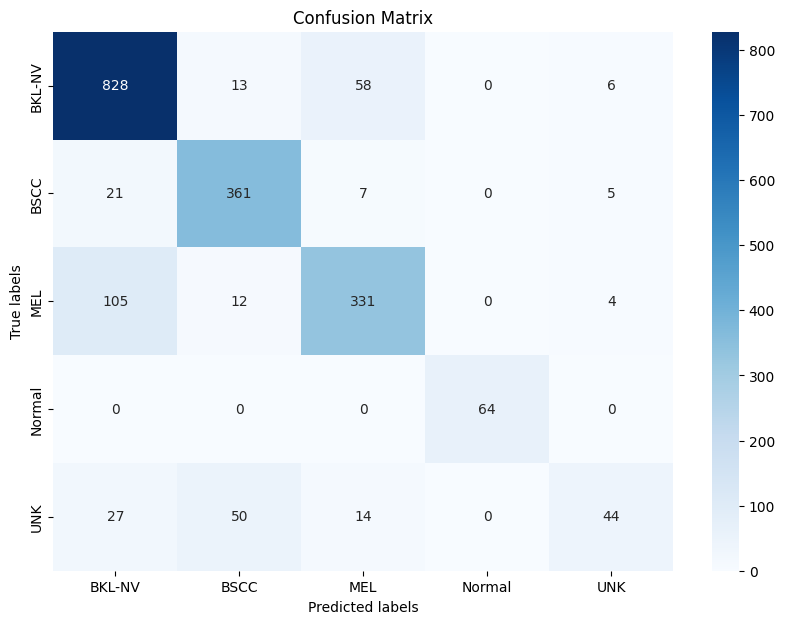

In [4]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns  # For a nicer confusion matrix plot
test_transforms = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
])

test_dir = '../isic2019_modified/isic2019_modified/test'  # specify the path to your test data   # specify the path to your test data
image_datasets['test'] = datasets.ImageFolder(test_dir, test_transforms)

dataloaders['test'] = torch.utils.data.DataLoader(
    image_datasets['test'],
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

# Load the model
model = MobileNetCustom(num_classes)
model.load_state_dict(torch.load('mobilenet_320_best_with_trans.pth', map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

# Initialize the prediction and actual label lists
test_predictions = []
test_actual = []

# Ensure the test loader is correctly set
test_loader = dataloaders['test']

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.view(-1).cpu().numpy())
        test_actual.extend(labels.view(-1).cpu().numpy())

# Convert lists to numpy arrays
test_predictions = np.array(test_predictions)
test_actual = np.array(test_actual)

# Calculate metrics
test_accuracy = np.mean(test_predictions == test_actual)
precision = precision_score(test_actual, test_predictions, average='weighted')
recall = recall_score(test_actual, test_predictions, average='weighted')
f1 = f1_score(test_actual, test_predictions, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Compute and plot confusion matrix
cm = confusion_matrix(test_actual, test_predictions)
plot_confusion_matrix(cm, class_names=['BKL-NV', 'BSCC', 'MEL', 'Normal', 'UNK'])  
